<a href="https://colab.research.google.com/github/gianluigilopardo/covid-19/blob/master/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stima giornaliera del valore $R_t$ del COVID-19 nelle regioni italiane**
*Lucia Innocenti, Gianluigi Lopardo - dati aggiorati al 23 Aprile 2020*

## 1. Introduzione

Basandoci sul [lavoro svolto](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb) per gli USA da [Kevin Systrom](https://it.wikipedia.org/wiki/Kevin_Systrom) per la stima del cosidetto valore $R_0$ (ovvero il [numero di riproduzione di base](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/id/5268851)) del **COVID-19**, abbiamo provato ad applicare la stessa analisi alle regioni italiane, sulla base dei [dati forniti](http://opendatadpc.maps.arcgis.com/apps/opsdashboard/index.html#/b0c68bce2cce478eaac82fe38d4138b1) dal Dipartimento della Protezione Civile.

I risultati possono essere utili per valutare l'effettiva efficacia delle misure di contenimento sia nazionali che regionali e, in base ad essi, definire i successivi passi nella gestione della pandemia.

Quella presentata è una versione modificata di una soluzione sviluppata da [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) per stimare $R_t$ in tempo reale usando un **approccio bayesiano**. L'articolo di Kevin Systrom migliora la stima del valore statico di $R$, introducendo un modello di processo con rumore gaussiano per stimare un $R_t$ variabile nel tempo.


Utilizziamo quindi il **Teorema di Bayes**: $$ P(R_t|k)=\frac{P(k|R_t)\cdot P(R_t)}{P(k)} $$
Questo dice che, avendo osservato $k$ nuovi casi, la distribuzione di $R_t$ sia uguale a:
*  la probabilità di osservare $k$ nuovi casi dato $R_t$, moltiplicata per
*  la stima *a priori* $P(R_t)$  del valore $R_t$ di senza i dati 
*  diviso per la probabilità di vedere $k$ nuovi casi in generale.

Questo è per un solo giorno. Iterando: ogni giorno che passa, usiamo la distribuzione *a posteriori* di ieri $P(R_{t-1}|k)$ per stimare il valori *a priori* $P(R_t)$ di oggi. Assumiamo che la distribuzione di $R_t$ sia una Gaussiana centrata in $R_{t-1}$, quindi $P(R_t|R_{t-1})=\mathcal{N}(R_{t-1},\sigma) $, dove la deviazione standard $\sigma$ è un iperparametro, ovvero un valore che verrà stimato di volta in volta.

Quindi, il primo giorno:
$$P(R_1|k_1)\propto P(R_1)\cdot\mathcal{L}(R_1|k_1)$$

Il secondo giorno:
$$P(R_2|k_1,k_2) \propto P(R_2)\cdot\mathcal{L}(R_2|k_2) = {P(R_1|k_1)\cdot P(R_2|R_1) \cdot \mathcal{L}(R_2|k_2)}$$
e così via.

Come funzione di *verosomiglianza*, usiamo la [distribuzione di Poisson](https://it.wikipedia.org/wiki/Distribuzione_di_Poisson), definita come: $$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

La relazione tra $\lambda$ e $R_t$ ([derivata qui](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185)) è: $$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$
dove $k_{t-1}$ è il numero di nuovi casi nel giorno $t-1$ e $\gamma$ è il reciproco dell'intervallo seriale, stimato in [circa 7 giorni](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article). 


## 2. Applicazione del modello alle regioni italiane
I dati utilizzati sono quelli forniti dal Ministero della Salute ed elaborati dal Dipartimento della Protezione Civile, che quotidianamente fornisce il [Monitoraggio della situazione](http://opendatadpc.maps.arcgis.com/apps/opsdashboard/index.html#/b0c68bce2cce478eaac82fe38d4138b1).

### 2.1 Setup
Preparazione dei dati e delle strutture dati utilizzate nell'algoritmo.

In [0]:
# Importing packages
import pandas as pd
import numpy as np

from scipy import stats as sps
from scipy.interpolate import interp1d

from pathlib import Path 

from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date, timedelta

from google.colab import files

from IPython.display import clear_output

In [2]:
# Importing data
sdate = date(2020, 2, 24) + timedelta(days=1)  # start date
edate = date.today() #- timedelta(days=1)  # last date

delta = edate - sdate + timedelta(days=1)  # number of reports available until today

url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-" \
      + str(edate.year) + '{:02d}'.format(edate.month) + '{:02d}'.format(edate.day) + ".csv"

dateparser = lambda x: pd.to_datetime(x).date  # .date cut off time
regions_new = pd.read_csv(url,
                     usecols=['data', 'denominazione_regione', 'nuovi_positivi'],
                     parse_dates=['data'],
                     date_parser = dateparser,
                     index_col=['denominazione_regione', 'data'],
                     squeeze=True).sort_index()

for i in range(delta.days):
    day = edate - timedelta(days=i + 1)
    url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-" \
          + str(day.year) + '{:02d}'.format(day.month) + '{:02d}'.format(day.day) + ".csv"
    regions = pd.read_csv(url,
                     usecols=['data', 'denominazione_regione', 'nuovi_positivi'],
                     parse_dates=['data'],
                     date_parser = dateparser,
                     index_col=['denominazione_regione', 'data'],
                     squeeze=True).sort_index()
    regions_new = pd.concat([regions, regions_new], axis=0, ignore_index=False)
regions = regions_new.copy()

regions.head()

denominazione_regione  data      
Abruzzo                2020-02-24     0
Basilicata             2020-02-24     0
Calabria               2020-02-24     0
Campania               2020-02-24     0
Emilia-Romagna         2020-02-24    18
Name: nuovi_positivi, dtype: int64

Sappiamo che la segnalazione dei casi nel tempo è molto irregolare. I nuovi casi vengono registrati quando si ha a disposizione l'esito del tampone. Il tempo impiegato per ottenere i risultati dipene dalle singole regioni, così come i criteri adottati per decidere chi sottoporre al test. Questo causa forti variabilità e imprecisioni nel conteggio dei nuovi casi giornalieri.

Per ottenere la migliore visualizzazione possibile dei dati "reali", è opportuno applicare un filtro gaussiano alle serie temporali, in modo da regolarizzare la curva dei contagi, riducendo il rumore sui dati.

In [0]:
# Gaussian smooth function
def prepare_cases(cases, cutoff = 3): 
  # cutoff: minimum number of new cases to consider each day
    smoothed = cases.rolling(7, # mobile window of a week
        win_type = 'gaussian',
        min_periods = 1, # windows step
        center=True).mean(std=2).round()
    idx_start = np.searchsorted(smoothed, cutoff) # indexes of days with more than cutoff new cases
    smoothed = smoothed.iloc[idx_start:] # smoothed values
    original = cases.loc[smoothed.index] # original values 
    return original, smoothed

Mostriamo un esempio di quanto ottenuto sui dati della Lombardia.

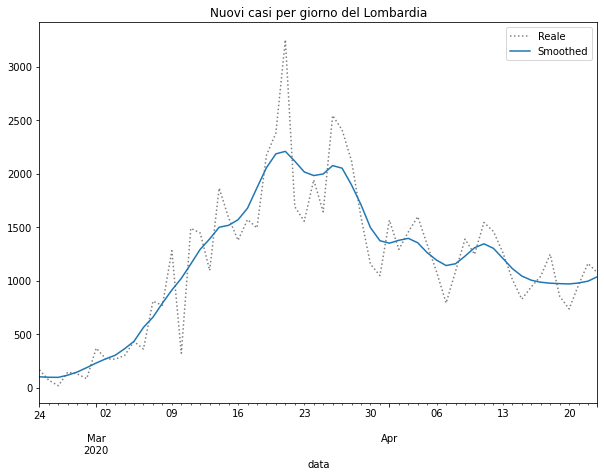

In [4]:
region_name = 'Lombardia' # as example

cases = regions.xs(region_name).rename(f"Casi in {region_name}")

original, smoothed = prepare_cases(cases, cutoff = 3)

fig, ax = plt.subplots()

original.plot(title = f"Nuovi casi per giorno del {region_name}",
               c = 'k',
               linestyle = ':',
               alpha = .5,
               label = 'Reale',
               legend = True,
               figsize = (10, 7))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

### 2.2 Esecuzione dell'algoritmo
Per calcolare i valori *a posteriori* di $R_t$ seguiamo questi passaggi:

1. Calcolo $\lambda$: il rate di arrivo previsto per il processo di Poisson per ogni giorno
2. Calcolo la funzione di *verosomiglianza* giornaliera su tutti i possibili valori di $R_t$
3. Calcolo la matrice del processo in base al valore di $\sigma$ 
4. Calcolo il valore *a priori* iniziale: il  primo giorno non ha un giorno precedente da cui prendere la distribuzione *a posteriori*
  * In base alle [informazioni del cdc](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article) sceglieremo $\gamma=\frac{1}{7}$
5. Itero dal primo giorno all'ultimo disponibile, procedendo come segue:
  * Calcolo il valore *a priori* di $R_t$ per il giorno $t$ in considerazione, applicando la Gaussiana al valore *a posteriori* del giorno precedente $t-1$
  * Applico la regola di Bayes moltiplicando il valore *a priori* ottenuto e il valore della funzione di verosomiglianza calcolato nel punto 2
  * Divido per la probabilità dei dati per normalizzare


In [0]:
GAMMA = 1/7
# We create an array for every possible value of R_t
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

def get_posteriors(sr, sigma=0.15): 
    
    # (1) Calculate Lambda
    lam = sr[:-1].values*np.exp(GAMMA*(r_t_range[:, None]-1)) 
    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix 
    process_matrix = sps.norm(loc = r_t_range,
                             scale = sigma
                             ).pdf(r_t_range[:, None]) 
    # process_matrix = sps.gamma(a = r_t_range, scale = sigma).pdf(r_t_range[:, None])

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)

    # (4) Calculate the initial prior
    prior0 = sps.gamma(a = 4).pdf(r_t_range)
    #prior0 = np.ones_like(r_t_range)/len(r_t_range) #flat prior
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index = r_t_range,
        columns = sr.index,
        data = {sr.index[0]: prior0}
    )
    
    # We keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)*P(R_t)
        numerator = likelihoods[current_day]*current_prior
        
        #(5c) Calculuate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

Il grafico mostra l'andamento delle distribuzioni a posteriori tracciate simultaneamente. Il colore delle curve diventa più scuro nel tempo. I valori *a posteriori* iniziano senza molta "fiducia" (curve ampie) e diventano progressivamente più "sicuri" (curve più ristrette) sul valore reale di $R_t$.

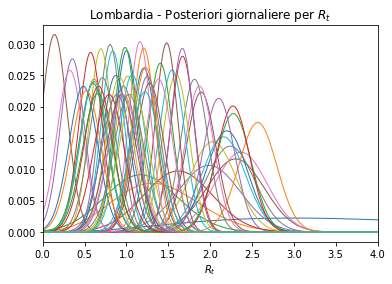

In [6]:
ax = posteriors.plot(title=f'{region_name} - Posteriori giornaliere per $R_t$',
           legend = False, 
           lw = 1,
           alpha = 1,
           #colormap = 'Blues',
           xlim = (0,4))

ax.set_xlabel('$R_t$');

Poiché i nostri risultati includono incertezza, teniamo conto sia del valore stimato (il più probabile) di $R_t$ che del suo intervallo di confidenza al 90%.

In [0]:
def highest_density_interval(pmf, p = 0.9):
    if(isinstance(pmf, pd.DataFrame)):
         # dato il dataframe posteriors, lo suddivide in N oggetti di Series, 
         # dove N è il numero dei giorni presi in considerazione.
         # ad ogni Series applica l'algoritmo sotto; 
         # una volta eseguito l'algoritmo per tutte le Series, 
         # inserisce i risultati in un dataframe e lo restituisce alla funzione chiamante                         
      return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf], 
                            index=pmf.columns)
      
    # da qui in poi, pmf è una lista composta dai 1201 (=#rt_range) elementi del 
    # Posteriori dato un giorno t

    #somma cumulativa dei posteriori:
    cumsum = np.cumsum(pmf.values) 

    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None] 
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    #lows -> restituisce l'indice di riga dei valori per cui total_p > p
    #highs -> restituisce l'indice di colonna dei valori per cui totale_p > p

    # Find the smallest range (highest density)
    best = (highs-lows).argmin() 

    low = pmf.index[lows[best]] # Low_p
    high = pmf.index[highs[best]] # High_p
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

Vediamo ad esempio i valori per gli ultimi 4 giorni giorni per la Lombardia.

In [8]:
# This takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)
most_likely = posteriors.idxmax().rename('ML')

result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
data,,,
2020-04-19,0.94,0.63,1.23
2020-04-20,0.97,0.65,1.25
2020-04-21,1.03,0.71,1.31
2020-04-22,1.09,0.76,1.36
2020-04-23,1.22,0.91,1.50


### 2.3 Visualizzazione
Definiamo la funzione che useremo per la visualizzazione dei risultati ottenuti, includendo sia il valore stimato di $R_t$ che l'area di confidenza.

In [0]:
def plot_rt(result, ax, region_name):
    
    ax.set_title(f"{region_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('data')

    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-02-24'),
                             end=index[-1]+pd.Timedelta(days=1))

    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(-1.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-02-20'), pd.Timestamp(date.today()-timedelta(days=1)))
    fig.set_facecolor('w')

Vediamo l'esempio sempre per la regione Lombardia.

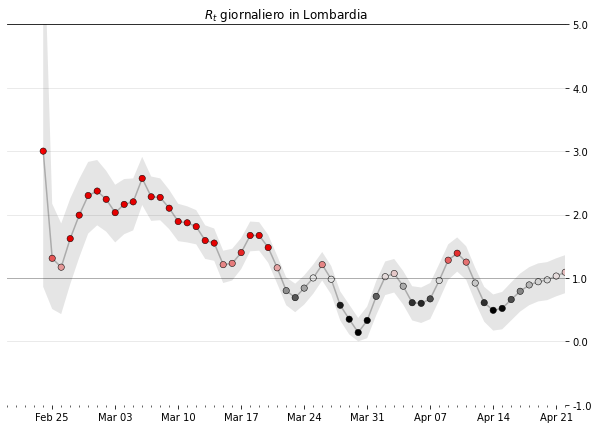

In [10]:
fig, ax = plt.subplots(figsize=(10,7))

plot_rt(result, ax, region_name)
ax.set_title(f'$R_t$ giornaliero in {region_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### 2.4 Scelta del $\sigma$ ottimale
Finora abbiamo assunto solo un valore arbitrario di $\sigma$. A questo punto però possiamo però stimare il valore ottimale di $\sigma$ per ogni regione, cioè quello che massimizza la probabilità $P(k)$. 

Per farlo, sommiamo tutte le *log-verosomiglianza* per regione per ogni valore di sigma, quindi scegliamo il massimo.

In [11]:
sigmas = np.linspace(1/20, 1, 20)

results = {}

for region_name, cases in regions.groupby(level='denominazione_regione'):
    
    print(region_name)
    new, smoothed = prepare_cases(cases)
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of regions name
    results[region_name] = result
    clear_output(wait=True)

print('Fatto.')

Fatto.


Ora che abbiamo le *log-verosomiglianze* di tutte le regioni, possiamo sommarle per ogni valore di sigma e quindi scegliere il massimo.

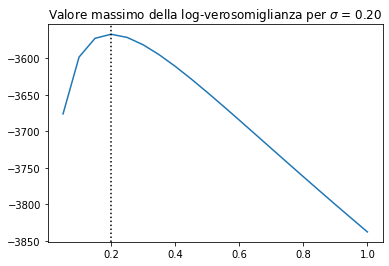

In [12]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each regions's results and add the log likelihoods to the running total.
for region_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Valore massimo della log-verosomiglianza per $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

## 3. Risultati finali
Una volta selezionato il $\sigma$ ottimale, valutiamo le distribuzioni *a posteriori* calcolate in precedenza in quel valore di $\sigma$ per ogni regione. Calcoliamo anche gli intervalli di confidenza del 90% e 50% e anche il valore più probabile.

In [13]:
final_results = None

for region_name, result in results.items():
    print(region_name)
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    if final_results is None:
        final_results = result
    else:
        final_results = pd.concat([final_results, result])
    clear_output(wait=True)

print('Fatto.')

Fatto.


In [0]:
# Per esporare i risultati
final_results.to_csv('rt_italia.csv')
#files.download('rt_italia.csv')

### 3.1 Andamento per ogni regione

AxesSubplot(0.398529,0.787927;0.227941x0.0920732)


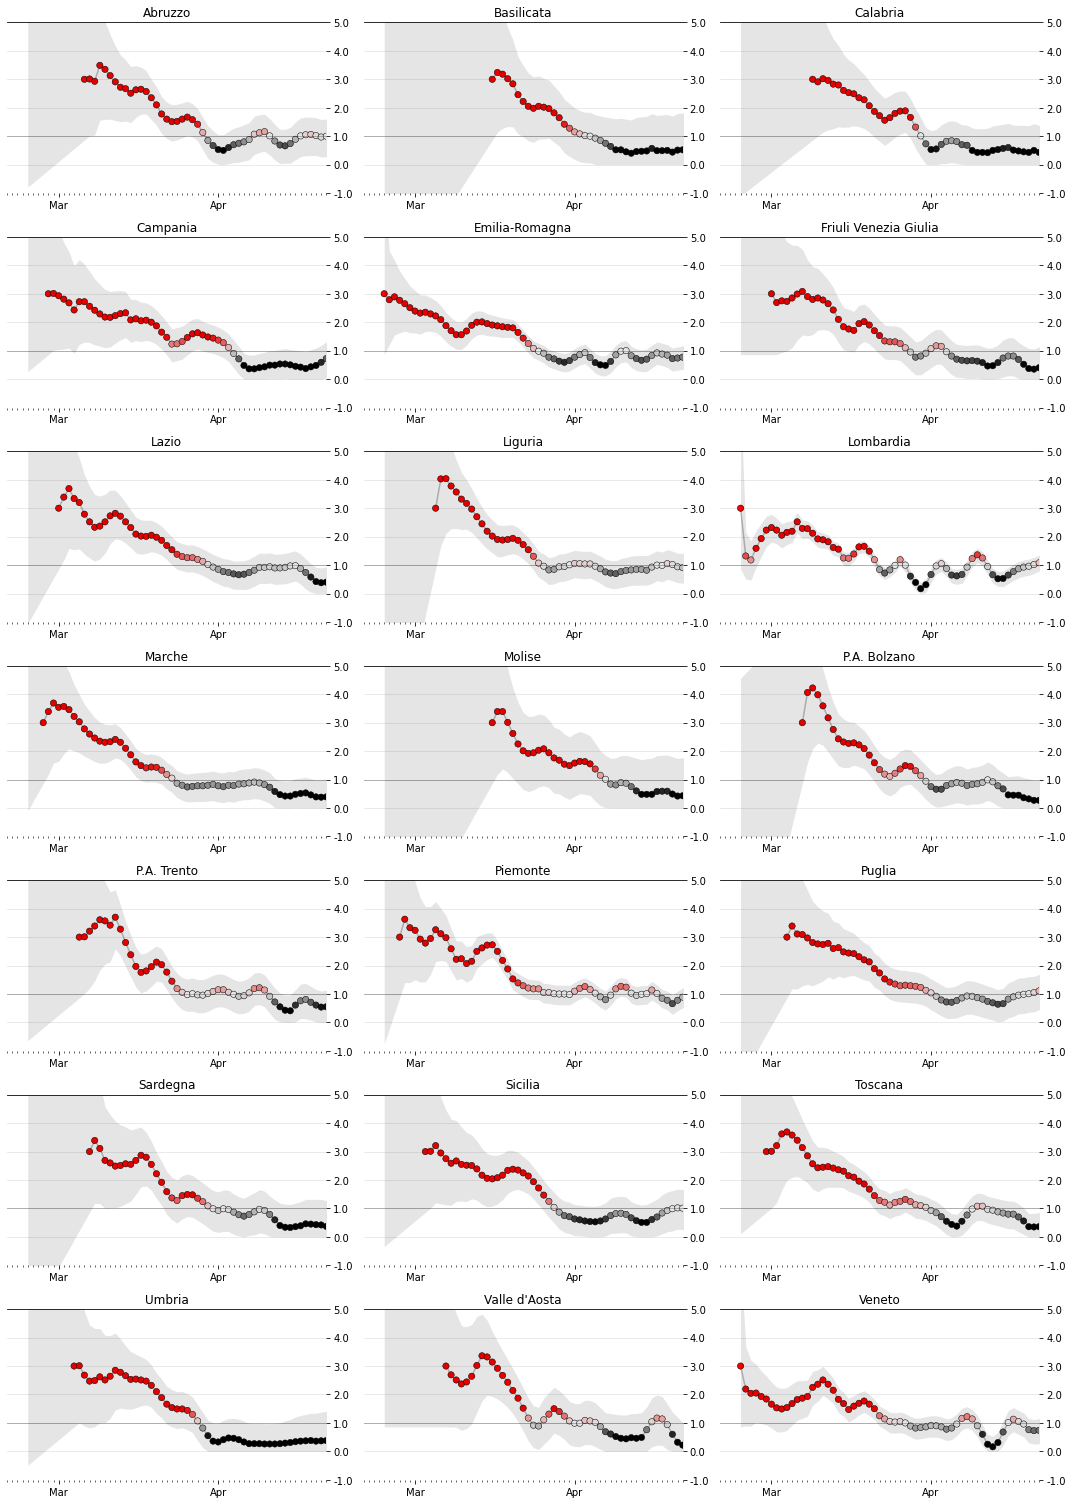

In [15]:
ncols = 3
nrows = int(np.ceil(len(results)/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
print(axes.flat[1])
for i, (region_name, result) in enumerate(final_results.groupby('denominazione_regione')):
    plot_rt(result, axes.flat[i], region_name)

fig.tight_layout()
fig.set_facecolor('w')

### 3.2 Valore più recente

(<Figure size 488.016x180 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9f0f5da7b8>)

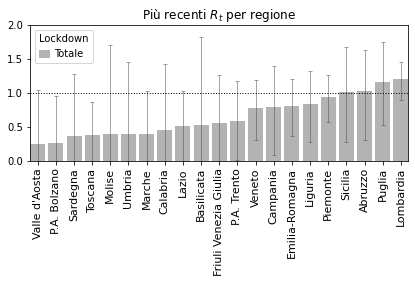

In [16]:
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

mr = final_results.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

def plot_standings(mr, figsize=None, title='Più recenti $R_t$ per regione'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    labels = mr.index.to_series()
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Totale', color=FULL_COLOR),
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr)

## 4. Riferimenti
1. [Estimating COVID-19's $R_t$ in Real-Time](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb), [Kevin Systrom](https://twitter.com/kevin)
2. [Che cos’è R0 e perché è così importante](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/id/5268851), [Istituto Superiore di Sanità](https://www.iss.it/)
3. [Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185),  Bettencourt & Ribeiro 2008
4. [High Contagiousness and Rapid Spread of Severe Acute Respiratory Syndrome Coronavirus 2](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article), Steven Sanche, Yen Ting Lin, Chonggang Xu, Ethan Romero-Severson, Nick Hengartner, and Ruian Ke